# Zero-shot kNN Regression for Redshift Estimation

In this notebook, we will use the the generated embeddings to estimate redshifts using k-NN regression.

In [7]:
from astroclip.utils import load_config, format_axes
from astroclip.training_utils import create_dataloaders, get_cross_modal_transforms
import matplotlib.pyplot as plt

import torch
import numpy as np

In [8]:
!mkdir out

mkdir: out: File exists


## Load the data, and generated embeddings

In [10]:
config, hparams = load_config('local', 'generate_embeddings')

cache_dir = config['cache_dir']
output_dir = config['output_dir']

batch_size = hparams['batch_size']
num_workers = config['num_workers']

dataset, train_loader, val_loader = create_dataloaders(cache_dir, batch_size, num_workers, val_drop_last=False)

# load all of the embedded spectra and images, as well as the corresponding redshifts
all_spectrum_embeddings = torch.load(f'out/spectrum_embeddings.pt').numpy()
all_image_embeddings = torch.load(f'out/image_embeddings.pt').numpy()
all_redshifts = dataset['test']['redshift'].numpy()

# load the valid indices, see downstream_tasks/README.md for more information on exactly what this is
valid_indices = torch.load(f'out/valid_indices.pt').numpy()

# drop out the invalid indices, see downstream_tasks/README.md for more information
valid_spectrum_embeddings = all_spectrum_embeddings[valid_indices]
valid_image_embeddings = all_image_embeddings[valid_indices]
valid_redshifts = all_redshifts[valid_indices]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/20 [00:00<?, ?it/s]

## Predict Redshifts using KNN Regression

In [13]:
from sklearn.neighbors import NearestNeighbors

def predict_redshifts(source_embedding, target_embedding, redshifts, n_neighbours=16):
    """
    Predict redshift for the embeddings given in source_embeddings, using their closest neighbours in
    target_embeddings.
    """
    assert (
        source_embedding.shape[0] == target_embedding.shape[0]
    ), 'Embeddings must have the same dimension'
    assert (
        source_embedding.shape[1] == target_embedding.shape[1]
    ), 'Embeddings must have the same dimension'
    
    num_embeddings = source_embedding.shape[0]
    actual_redshifts = redshifts[0 : target_embedding.shape[0]]

    neighbours = NearestNeighbors(n_neighbors=n_neighbours, algorithm='auto').fit(
        target_embedding
    )
    
    distances, indices = neighbours.kneighbors(source_embedding)
    predicted_redshifts = np.array(
        [actual_redshifts[indices[i]].mean() for i in range(num_embeddings)]
    )
    
    return actual_redshifts, predicted_redshifts

In [16]:
# ss_predicted_redshifts: predict redshifts using in-modal spectrum to spectrum neighbours
actual_redshifts, ss_predicted_redshifts = predict_redshifts(
    valid_spectrum_embeddings, valid_spectrum_embeddings, valid_redshifts
)

# ii_predicted_redshifts: predict redshifts using in-modal image to image neighbours
_, ii_predicted_redshifts = predict_redshifts(
    valid_image_embeddings, valid_image_embeddings, valid_redshifts
)

# si_predicted_redshifts: predict redshifts using cross-modal spectrum to image neighbours, predict the redshift of a given spectrum embedding by using its closes 16 image embeddings
_, si_predicted_redshifts = predict_redshifts(
    valid_spectrum_embeddings, valid_image_embeddings, valid_redshifts
)

_, is_predicted_redshifts = predict_redshifts(
    valid_image_embeddings, valid_spectrum_embeddings, valid_redshifts
)

## Plot the results

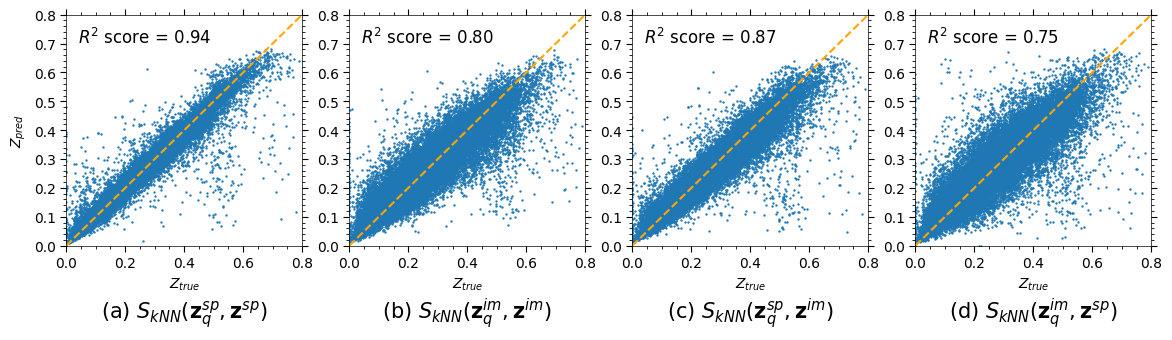

In [22]:
from sklearn.metrics import r2_score

def plot_r2_score(ax, redshifts, predicted_redshifts, title, ylabel=None):
    r2 = r2_score(redshifts, predicted_redshifts)
    
    ax.scatter(redshifts, predicted_redshifts, s=0.5)
    ax.set_xlim(0.0, 0.8)
    ax.set_ylim(0.0, 0.8)
    ax.plot(np.linspace(0, 0.8, 100), np.linspace(0, 0.8, 100), color='orange', linestyle='--')
    
    ax.set_xlabel(r'$Z_{true}$')
    ax.set_ylabel(ylabel)
    ax.text(0.04, 0.7, rf'$R^2$ score = {r2:.2f}', fontsize=12)
    # ax.suptitle(title, y=0.02, va='top')
    ax.set_title(title, fontsize=15, y=-0.35)

fig, ax = plt.subplots(figsize=(14, 3), nrows=1, ncols=4)
plot_r2_score(ax[0], actual_redshifts, ss_predicted_redshifts, title=r'(a) $S_{kNN}(\mathbf{z}_{q}^{sp}, \mathbf{z}^{sp})$', ylabel=r'$Z_{pred}$')
plot_r2_score(ax[1], actual_redshifts, ii_predicted_redshifts, title=r'(b) $S_{kNN}(\mathbf{z}_{q}^{im}, \mathbf{z}^{im})$')
plot_r2_score(ax[2], actual_redshifts, si_predicted_redshifts, title=r'(c) $S_{kNN}(\mathbf{z}_{q}^{sp}, \mathbf{z}^{im})$')
plot_r2_score(ax[3], actual_redshifts, is_predicted_redshifts, title=r'(d) $S_{kNN}(\mathbf{z}_{q}^{im}, \mathbf{z}^{sp})$')

format_axes(ax[0])
format_axes(ax[1])
format_axes(ax[2])
format_axes(ax[3])

plt.savefig('out/redshift_knn_regression.png', bbox_inches='tight')